In [1]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import time
import torch


from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')
colors = [
    'skyblue', 'orange', 'steelblue', 'gold', '#f58231', 'red' 
]
%matplotlib inline
linewidth = 3

In [ ]:
datafile='rand_preprocessed.pt'
device = torch.device("cpu")

In [ ]:
#showers = torch.load(datafile)

In [ ]:
len(showers)

In [ ]:
showers[0]

In [ ]:
lens=[]

for shower in showers:
    lens.append(len(np.unique(shower.y)))

plt.figure(figsize=(12, 8))
plt.title("Distribution of number of showers in brick \n")
plt.hist(lens, bins=15);
plt.savefig('showers_per_brick_distr.pdf', bbox_inches='tight')
plt.show()

In [ ]:
showers_data = []
for shower in showers:
    showers_data.append(shower.shower_data)

In [ ]:
showers_data = [item for sublist in showers_data for item in sublist]

In [ ]:
len(showers_data)

In [ ]:
numtracks = []
E_true = []

for shower in showers_data:
    numtracks.append(shower[-2].numpy())
    E_true.append(shower[0].numpy())


In [ ]:
max(np.array(numtracks))

In [ ]:
max(np.array(E_true))

In [ ]:
unique, index = np.unique(E_true, return_index=True)


In [ ]:
plt.hist(unique, bins=100);

In [ ]:
len(unique)

In [ ]:
ntrck_unique = np.array(numtracks)[index]

In [ ]:
E_true_sorted = unique.copy()

In [ ]:
E_true_sorted.sort()

In [ ]:
indexes_0_5_2 = [list(unique).index(E_true_sorted[i]) for i in range(1291)]
#1284
indexes_2_3 = [list(unique).index(E_true_sorted[i]) for i in range(1291, 2330)]
#1033
indexes_3_4 = [list(unique).index(E_true_sorted[i]) for i in range(2330, 3227)]
#888
indexes_4_5_5 = [list(unique).index(E_true_sorted[i]) for i in range(3227, 4340)]
#1110
indexes_5_5_7_5 = [list(unique).index(E_true_sorted[i]) for i in range(4340, 5374)]
#1032
indexes_7_5_11 = [list(unique).index(E_true_sorted[i]) for i in range(5374, 6476)]
#1102
indexes_11_22 = [list(unique).index(E_true_sorted[i]) for i in range(6476, 7565)]
#1088

In [ ]:
indx = [indexes_0_5_2, indexes_2_3, indexes_3_4, indexes_4_5_5,
       indexes_5_5_7_5, indexes_7_5_11, indexes_11_22]

In [ ]:
ind_name = ['from 0.5 to 2 Gev', 'from 2 to 3 Gev', 'from 3 to 4 Gev', 'from 4 to 5.5 Gev',
            'from 5.5 to 7.5 Gev', 'from 7.5 to 11 Gev', 'from 11 to 22 Gev', ]

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("Number of tracks distribution vs True Energy range \n")

for ind, name in zip(indx, ind_name):
    sns.distplot(ntrck_unique[ind], hist=True, rug=False, label=name)

plt.legend()    
plt.savefig("E_true_vs_numtracks_distr.pdf", bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("True Energy of EM shower vs the shower number of tracks \n")
plt.scatter((np.array(numtracks)[index]),unique)
plt.ylabel("True Energy")
plt.xlabel("Number of tracks")
# plt.ylim
plt.savefig("E_true_vs_numtracks.pdf", bbox_inches='tight')
plt.show()

# Energy resolution on random graph

In [194]:
def E_pred(E_raw, E_true, nshowers):
    #E_raw, E_true -- .npy files
    #name - string 
    E_raw = np.load(E_raw)
    E_true = np.load(E_true)
    assert(len(E_raw)==len(E_true))
    
    
    # transforming the data to include another axis
    #E_raw = E_raw[:, np.newaxis]
    #E_true = E_true[:, np.newaxis]

    polynomial_features= PolynomialFeatures(degree=2)
    E_raw_poly = polynomial_features.fit_transform(E_raw.reshape((-1, 1)))
    
    r = HuberRegressor()
    r.fit(X=E_raw_poly, y=E_true.reshape((-1, 1)))
    E_pred = r.predict(E_raw_poly)
    
    plt.figure(figsize=(10, 5), dpi=100)
    plt.title('Energy distribution comparison for '+ nshowers + ' per brick \n')
    sns.distplot(E_true, bins = 100, hist = True, label='True Energy')
    sns.distplot(E_pred, bins = 100, hist = True,  label='Predicted Energy')
    plt.legend(loc='upper right')
    plt.savefig(nshowers + ".pdf", bbox_inches='tight')
    plt.show()
    
    
    return E_pred, E_true
    

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


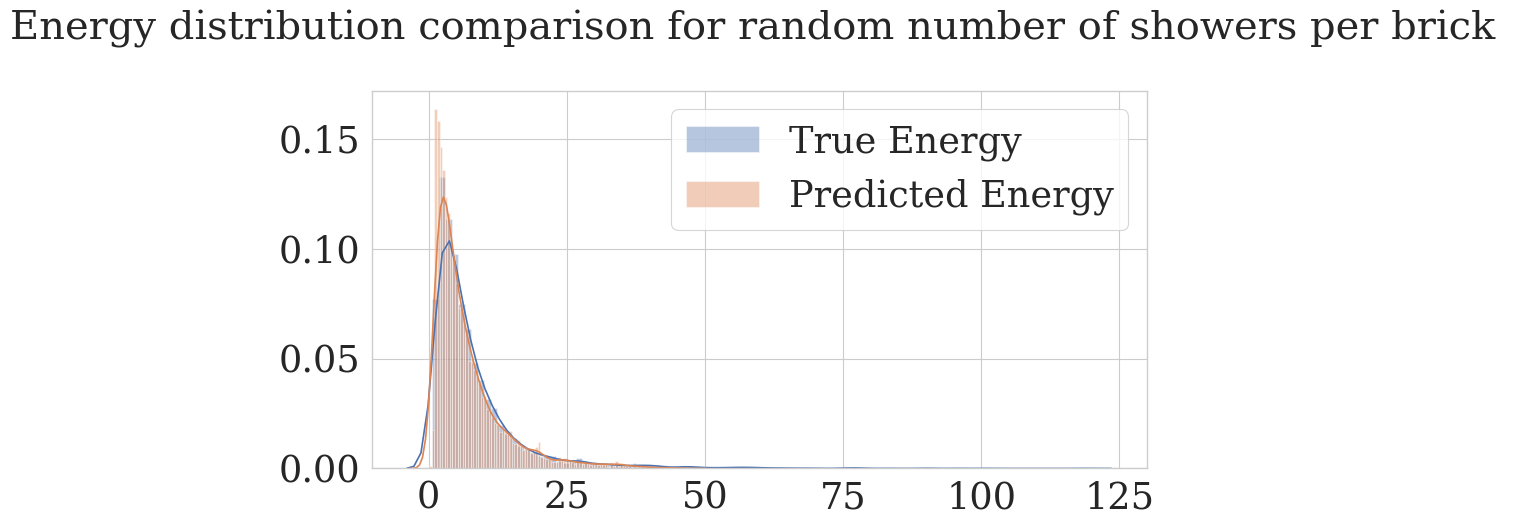

In [195]:
E_pred_rand, E_true_rand = E_pred('E_pred_rand.npy', 'E_true_rand.npy', 'random number of showers')

In [196]:
ER = np.load('ER_new1.npy')

In [197]:
n_showers = np.load('n_showers_new1.npy')

In [198]:
n = []

for i in range(len(n_showers)-1):
    if n_showers[i+1] != n_showers[i]:
        n.append(n_showers[i])
n.append(n_showers[-1])

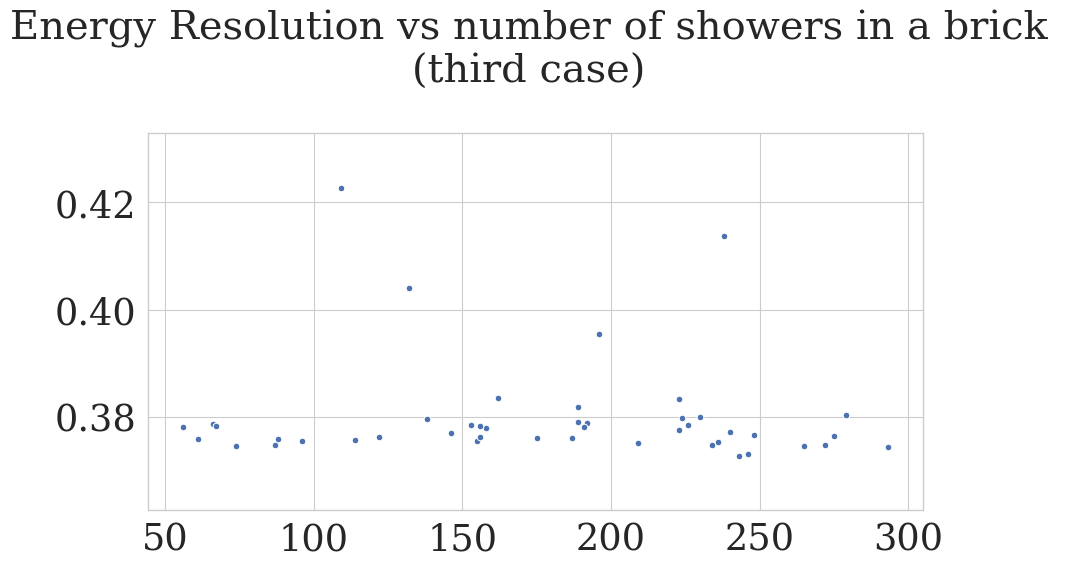

In [199]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Energy Resolution vs number of showers in a brick \n(third case) \n')

sns.scatterplot(n, ER)

plt.savefig('ER_per_brick_iid.pdf', bbox_inches='tight')
plt.show()

# Energy resolution dependence on number of showers in a brick 

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


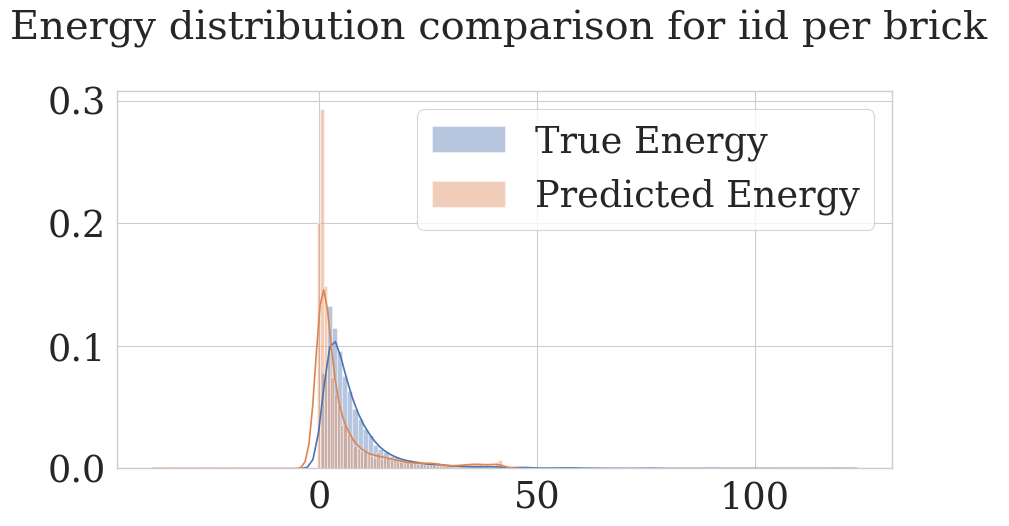

In [167]:
E_pred_iid, E_true_iid = E_pred('E_pred_rand_IID.npy', 'E_true_rand_IID.npy', 'iid')

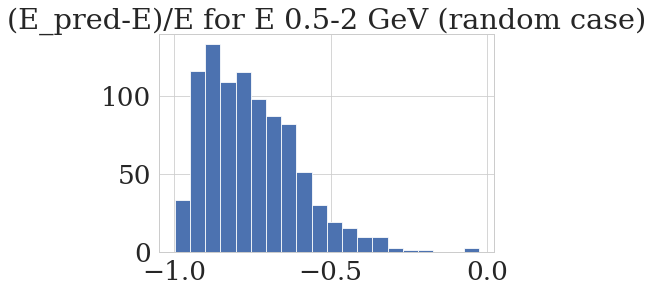

In [168]:
plt.hist((E_pred_rand[nshowers_dict['random'][1]]
          -E_true_rand[nshowers_dict['random'][1]])/E_true_rand[nshowers_dict['random'][1]], bins = 20);
plt.title('(E_pred-E)/E for E 0.5-2 GeV (random case)');

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


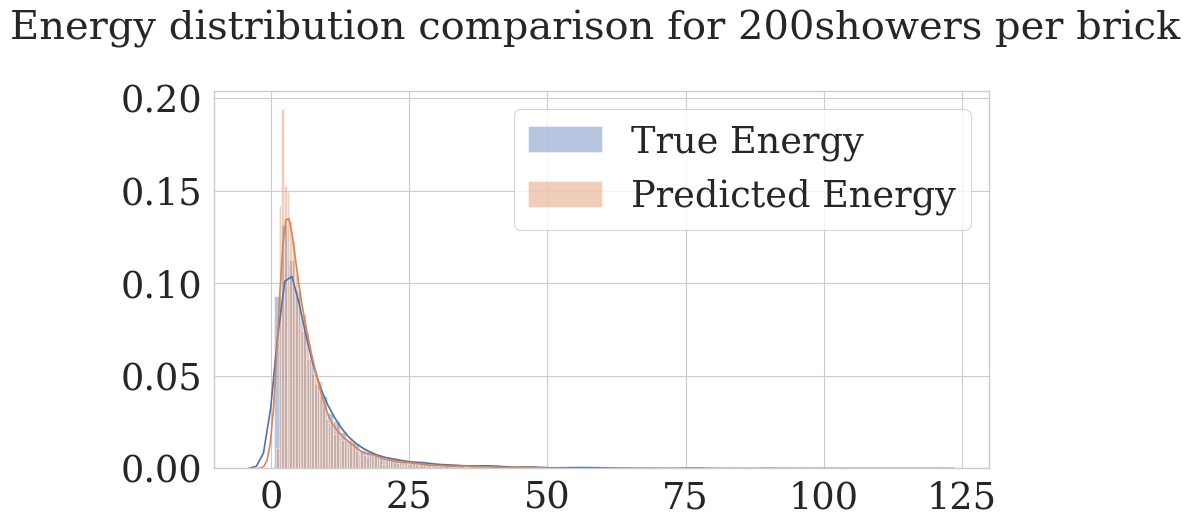

In [169]:
E_pred_200, E_true_200 = E_pred('E_pred.npy', 'E_true.npy', '200showers')

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


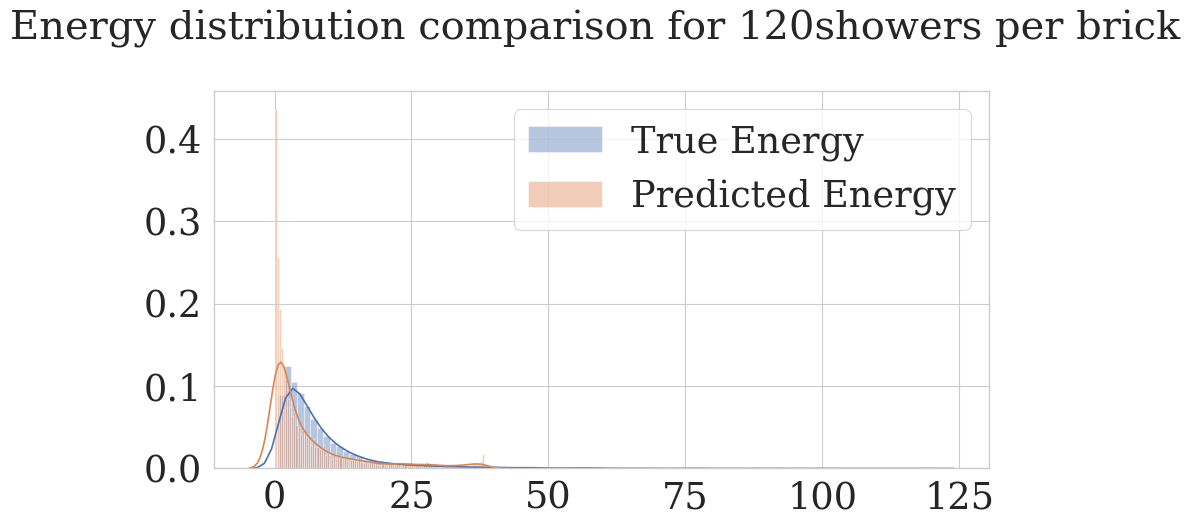

In [170]:
E_pred_120, E_true_120 = E_pred('E_pred_120shower.npy', 'E_pred_true_120shower.npy', '120showers')

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


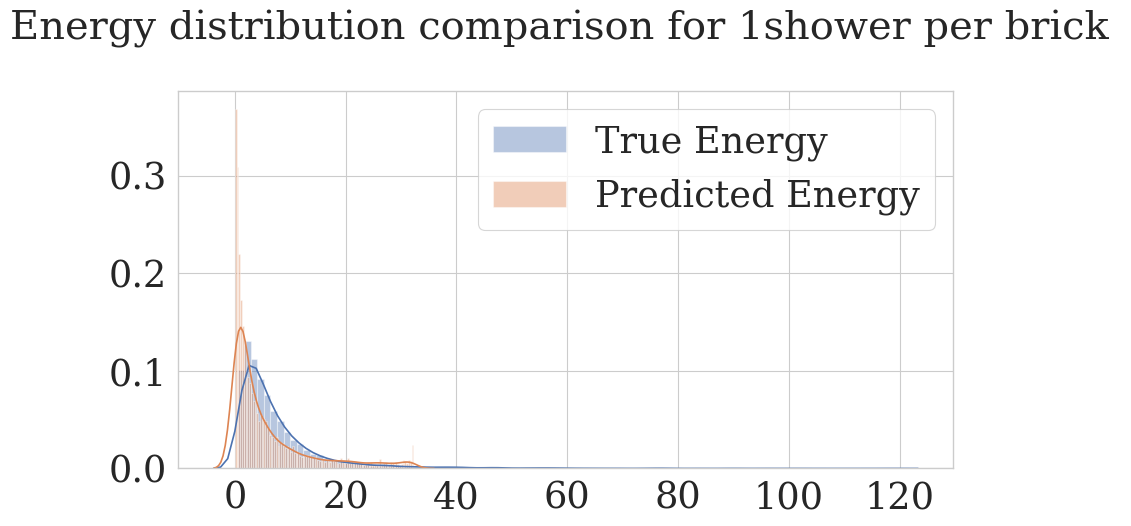

In [171]:
E_pred_1, E_true_1 = E_pred('E_pred_1shower.npy', 'E_pred_true_1shower.npy', '1shower')

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


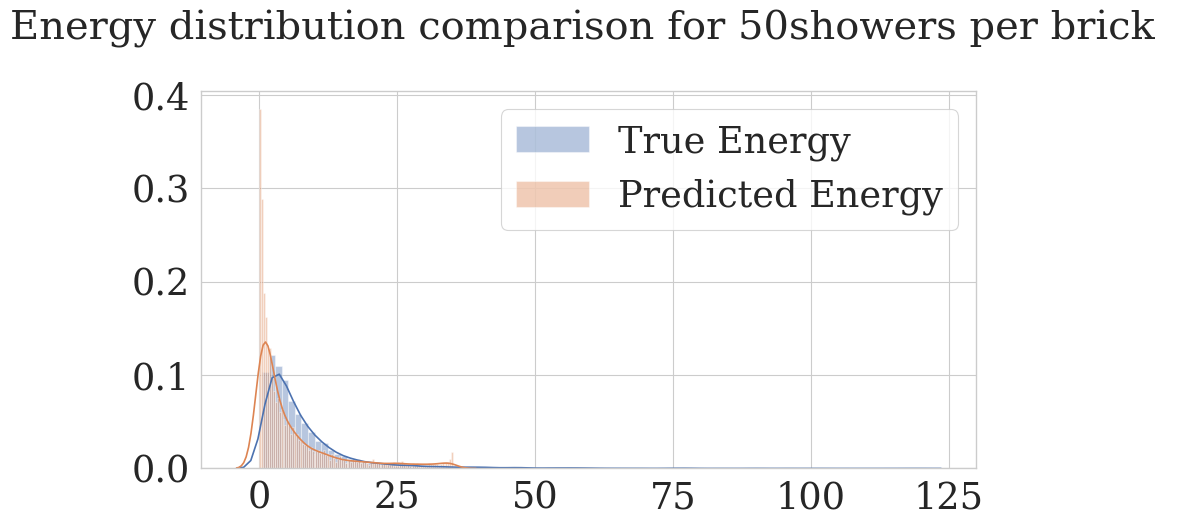

In [172]:
E_pred_50, E_true_50 = E_pred('E_pred_50shower.npy', 'E_pred_true_50shower.npy', '50showers')

/root/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


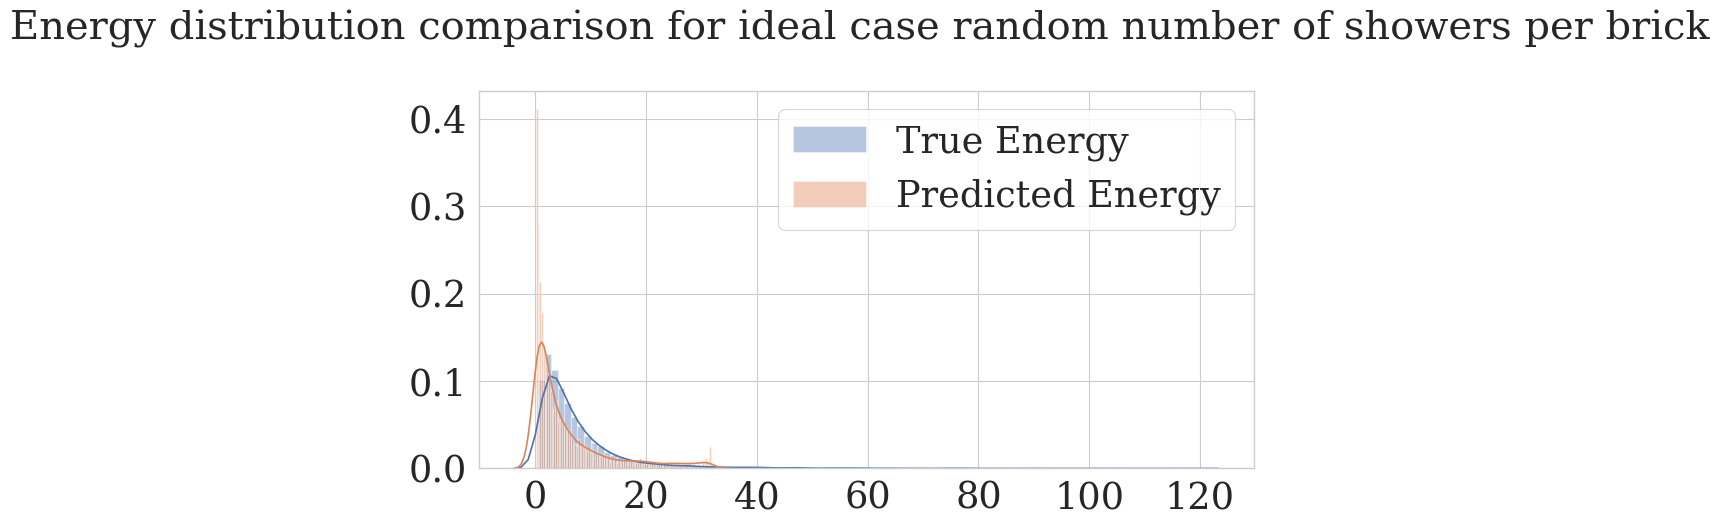

In [173]:
E_all, E_true_all = E_pred('E.npy', 'E_true_all.npy', 'ideal case random number of showers')

In [174]:
nshowers_dict = {'1shower': [], '50showers': [],  '120showers': [], '200showers': [], 
                 'ideal_case': [],  'random': []}

In [175]:
ER_dict = {'1shower': [], '50showers': [],  '120showers': [], '200showers': [], 'ideal_case': [],  'random': [],
           'baseline': [0.35, 0.32, 0.25, 0.22, 0.18, 0.16, 0.12]}

In [176]:
index_list_1 = [1284, 2317, 3205, 4315, 5347, 6449, 7537]
index_list_50 = [1063, 1907, 2669, 3638, 4537, 5512, 6497]
index_list_120 = [775, 1491, 2092, 2893, 3664, 4496, 5366]
index_list_200 = [1010, 1945, 2762, 3792, 4740, 5741, 6750]

In [177]:
index_list_ideal = [1292, 2331, 3228, 4341, 5375, 6478, 7567]
index_list_random = [831, 1743, 2529, 3542, 4493, 5500, 6502]

In [178]:
index_list_iid = [838, 1744, 2538, 3534, 4483, 5489, 6484]

In [179]:
E_true_sorted = E_true_iid.copy()
E_true_sorted.sort()
    
E_true_sorted = E_true_sorted.tolist()

In [ ]:
for i in range(len(E_true_sorted)):
    if E_true_sorted[i]>22:
        print(i)
        break

In [180]:
indices_list = [index_list_1, index_list_50, index_list_120, index_list_200,
                index_list_ideal, index_list_random]

In [181]:
E_pred_list = [E_pred_1/10, E_pred_50/10, E_pred_120/10, E_pred_200/10, E_all/10, E_pred_rand/10]
E_true_list = [E_true_1, E_true_50, E_true_120, E_true_200, E_true_all, E_true_rand]

In [182]:
n = ['1shower', '50showers',  '120showers', '200showers', 'ideal_case', 'random']

In [183]:
def Energy_boxes(E_pred, E_true, nshowers, index_list):
     #nshowers - string
    
    #Dividing Energy into 'boxes'
    E_true_sorted = E_true.copy()
    E_true_sorted.sort()
    
    E_true_sorted = E_true_sorted.tolist()
    E_true = E_true.tolist()
    
    ## return indices for every 'box' of Energy (from 0 to 2 GeV, from 2 to 3 GeV...)
    nshowers_dict[nshowers].append([E_true.index(E_true_sorted[i]) for i in range(index_list[0])])
    for i in range(len(index_list)-1):
        nshowers_dict[nshowers].append([E_true.index(E_true_sorted[i]) for i in range(index_list[i], 
                                                                                          index_list[i+1])])    

In [184]:
for i in range(len(indices_list)):
    Energy_boxes(E_pred_list[i], E_true_list[i], n[i], indices_list[i])

In [185]:
def ER(ind, E_pred, E_true):
    return np.std((np.array(E_true)[ind] - np.array(E_pred)[ind])
                 /np.array(E_true)[ind])

In [186]:
for i in range(len(E_pred_list)):
    nshowers = n[i]
    for ind in nshowers_dict[nshowers]:
        ER_dict[nshowers].append(ER(ind, E_pred_list[i], E_true_list[i]))

In [192]:
def plot_ER(nshowers):
    E_boxes = [2, 3, 4, 5.5, 7.5, 11, 22] 
    
    
    plt.figure(figsize=(16, 12), dpi=100)
    plt.title('Energy resoltion comparison for different number of showers in a brick (PolynomialFeatures(degree=3)) \n')
    
    for n in nshowers:
        plt.plot(E_boxes, ER_dict[n], marker = '*', label=n)


    plt.xlabel("E (GeV)");
    plt.ylabel("ER");
    
    plt.legend()

    plt.savefig("ER_comparison_LR.pdf", bbox_inches='tight')
    plt.show()

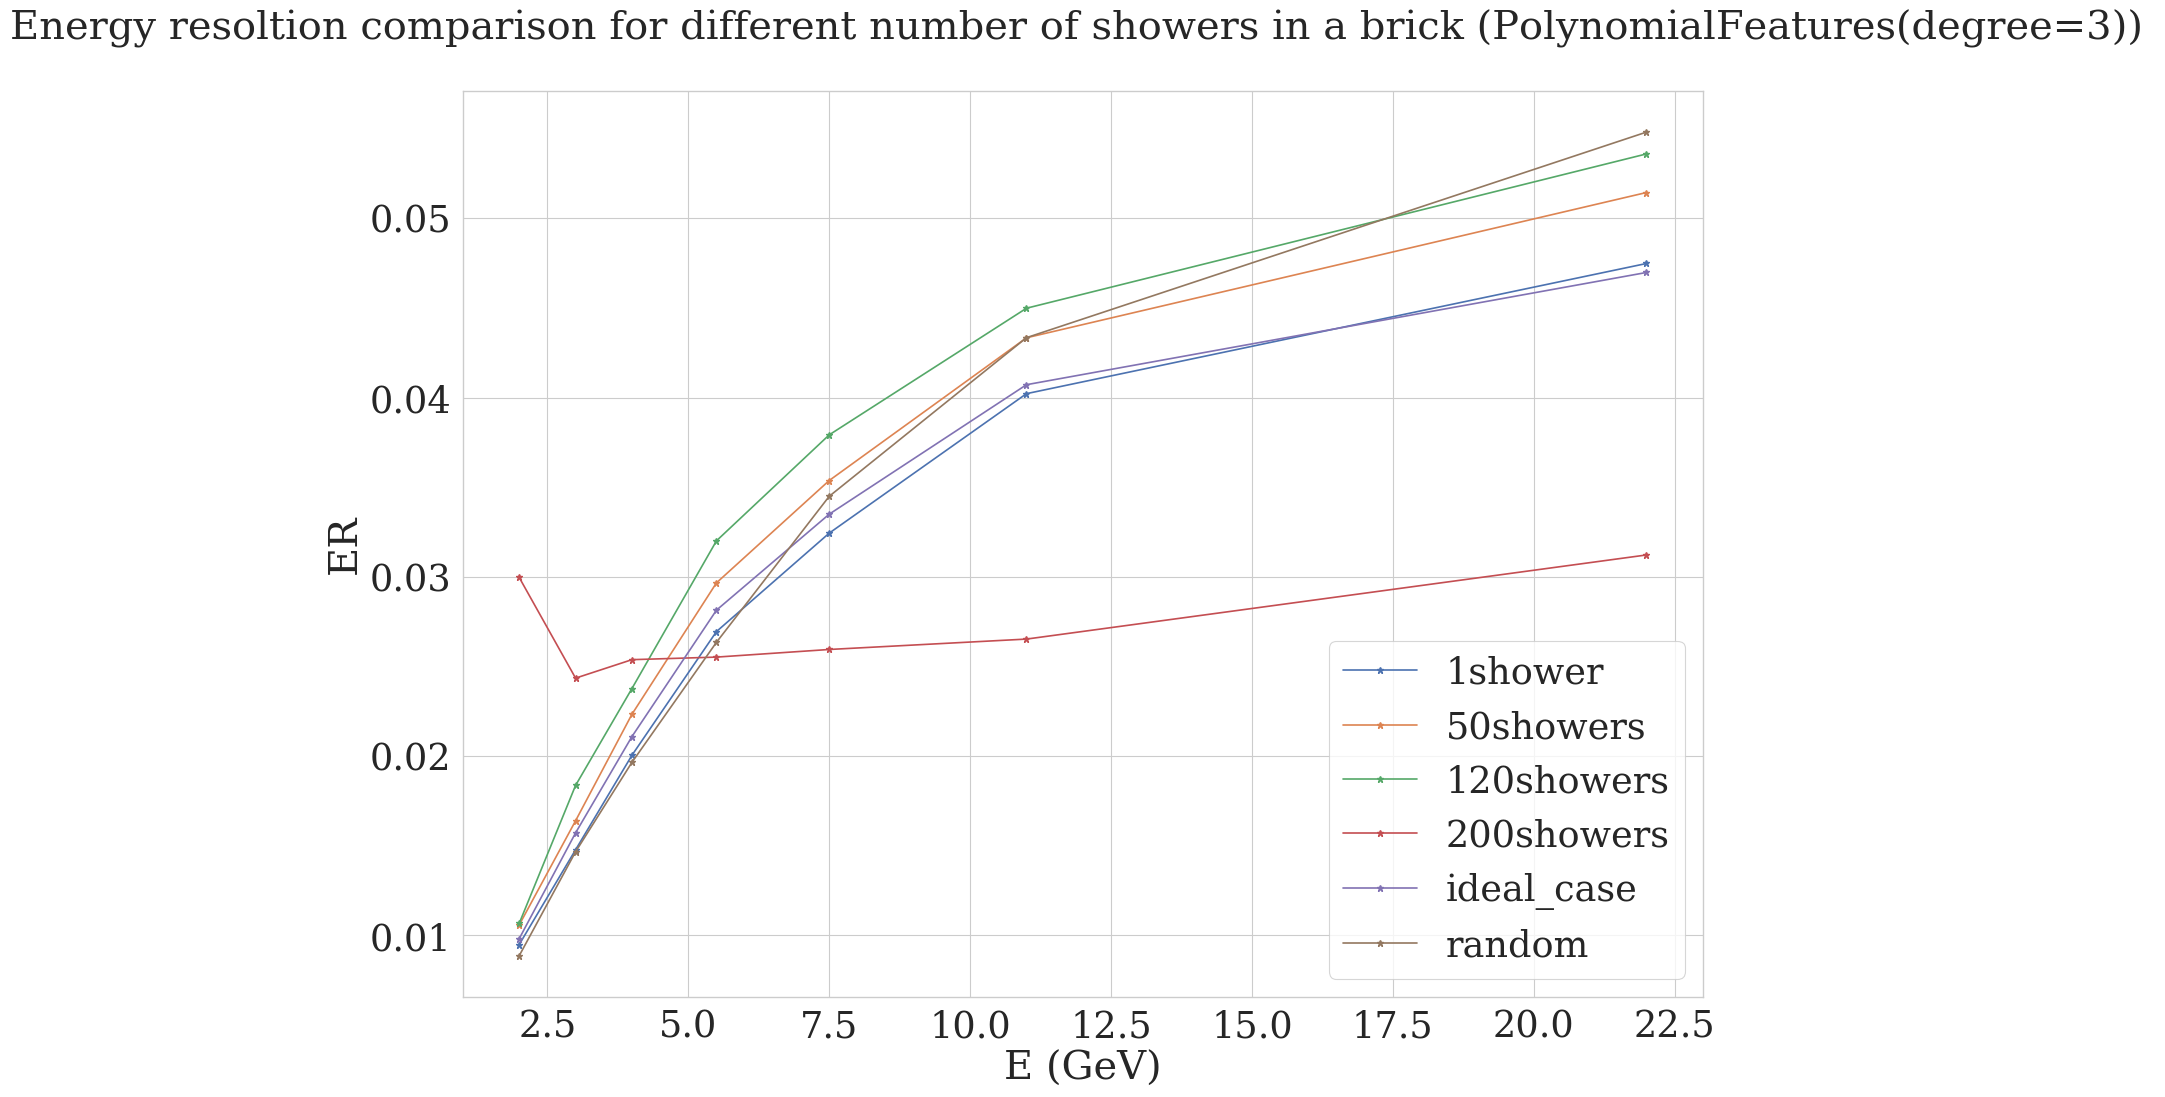

In [193]:
plot_ER(n)

# Ideal Case

In [189]:
ER_ideal = []

for ind in nshowers_dict['ideal_case']:
    ER_ideal.append(ER(ind, E_pred_list[-2], E_true_list[-2]))

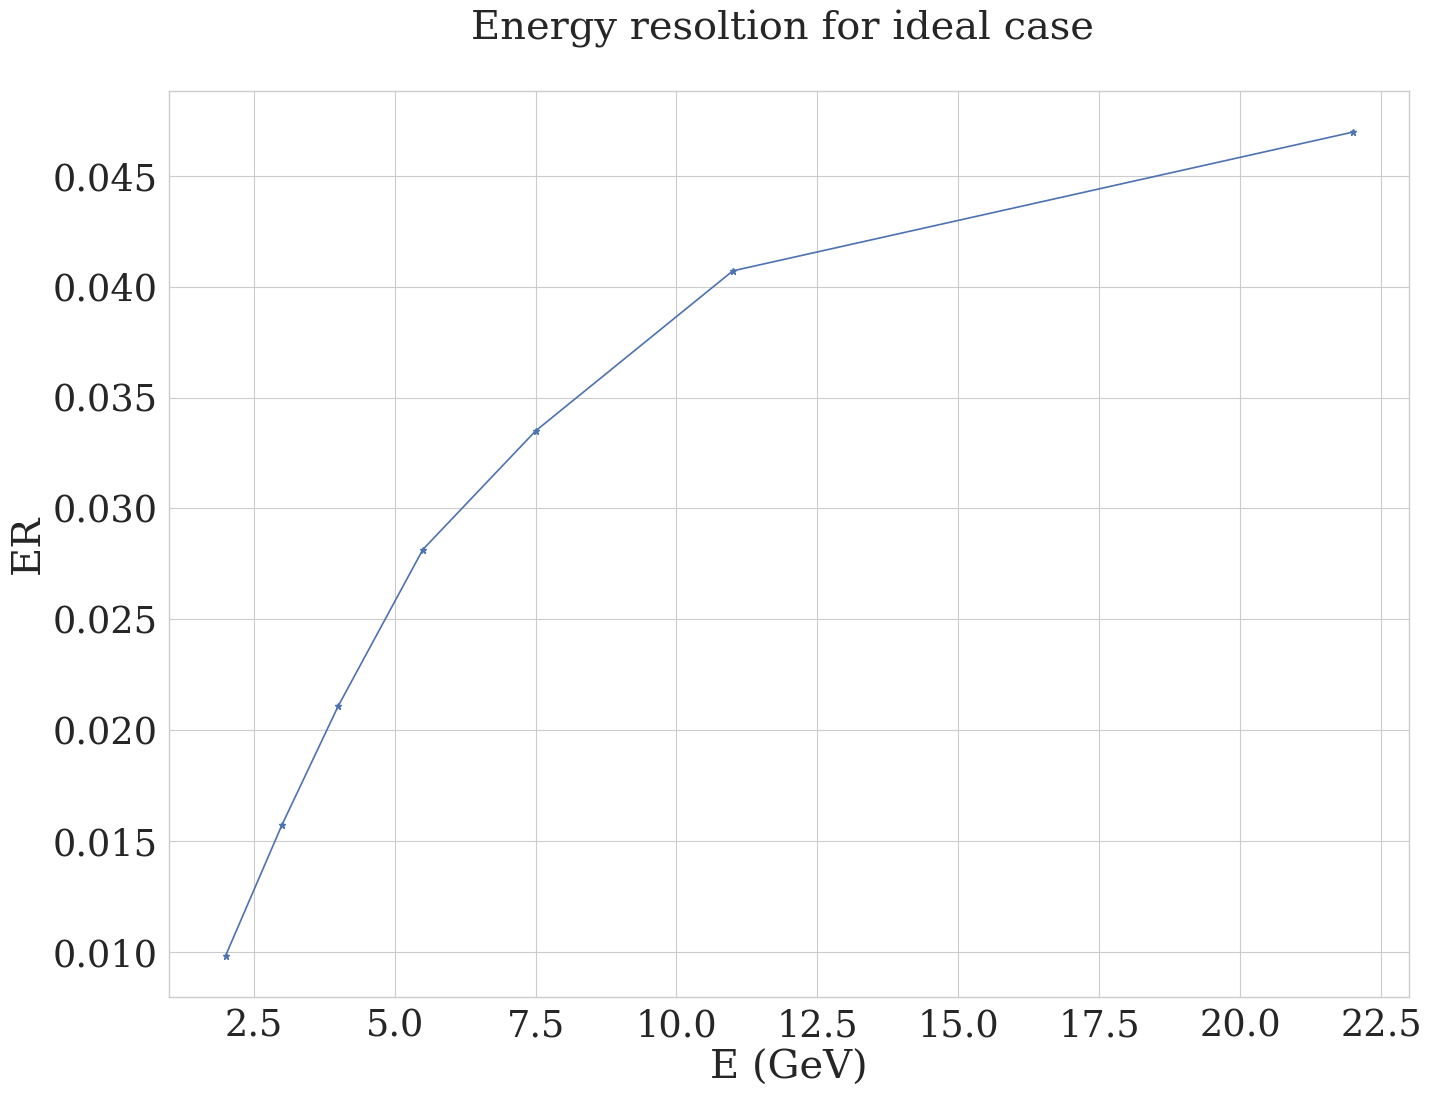

In [190]:
E_boxes = [2, 3, 4, 5.5, 7.5, 11, 22] 
    
    
plt.figure(figsize=(16, 12), dpi=100)
plt.title('Energy resoltion for ideal case \n')
    
plt.plot(E_boxes, ER_ideal, marker = '*')


plt.xlabel("E (GeV)");
plt.ylabel("ER");
    

plt.savefig("ER_ideal.pdf", bbox_inches='tight')
plt.show()

# Random case

In [191]:
ER_random = []

for ind in nshowers_dict['iid']:
    ER_random.append(ER(ind, E_pred_list[-1], E_true_list[-1]))

KeyError: 'iid'

In [ ]:
E_boxes = [2, 3, 4, 5.5, 7.5, 11, 22] 
    
    
plt.figure(figsize=(16, 12), dpi=100)
plt.title('Energy resoltion. Ideal vs new1 case \n')
    
for E, name in zip([ER_ideal, ER_random], ['Ideal case', "new1"]):
    plt.plot(E_boxes, E, marker = '*', label=name)


plt.xlabel("E (GeV)");
plt.ylabel("ER");
    
plt.legend()

plt.savefig("ER_comparison_Ideal_Random.pdf", bbox_inches='tight')
plt.show()